**Usage**

Go through the paper to understand what the data is about.
Download some datasets from https://github.com/mdeff/fma.
Uncompress the archives, e.g. with unzip fma_small.zip.
Load and play with the data in this notebook

In [ ]:
#import packages 
import os

import math
import json
import librosa
import librosa.display

import IPython.display as ipd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn as skl
import sklearn.utils, sklearn.preprocessing, sklearn.decomposition, sklearn.svm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding, Conv2D, BatchNormalization, AveragePooling1D,Flatten
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow.keras as keras

plt.rcParams['figure.figsize'] = (17, 5)

In [ ]:
# Directory where mp3 are stored.
AUDIO_DIR = os.environ.get('AUDIO_DIR')

# Load metadata and features.
tracks = utils.load('data/fma_metadata/tracks.csv')

tracks.shape

# 1 Data Pre-processing
The metadata table, a CSV file in the fma_metadata.zip archive, is composed of many colums:

The index is the ID of the song, taken from the website, used as the name of the audio file.
Per-track, per-album and per-artist metadata from the Free Music Archive website.
Two columns to indicate the subset (small, medium, large) and the split (training, validation, test).

# 1.1 Subsets
The small subset can be selected with the below code.

In [ ]:
small_tracks = tracks[tracks['set', 'subset'] <= 'small']
small_tracks.shape

# 1.2 Create a subset of id and genre
The small subset can be selected with the below code.

In [ ]:
genre_only = pd.DataFrame(small_tracks['track']['genre_top'])
genre_only

,genre
Unnamed: 0,
2,Hip-Hop
5,Hip-Hop
10,Pop
140,Folk
141,Folk
...,...
154308,Hip-Hop
154309,Hip-Hop
154413,Pop


# 1.3 Create a subset of only four genres (Pop, Folk, Rock, Electronic) 
The track categories are encoded as numbers

In [ ]:
# There are 8 top-level genre categories, however, we are selecting only 4
genres = genre_only[(genre_only['genre_top'] == "Pop" )|(genre_only['genre_top'] == "Folk")|(genre_only['genre_top'] == "Rock" )|(genre_only['genre_top'] == "Electronic")]
genres.replace(['Pop', 'Folk','Rock','Electronic'],[0,1,2,3], inplace=True)

genres.head()

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:5238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


,genre
Unnamed: 0,
10,0
140,1
141,1
182,2
190,1


# 1.4 Create a subset that selects 500 songs from each of the four genres
The small subset is selected with the code below. 

In [ ]:
#create genre subset. selecting 500 from each of the four genres
filtered = pd.concat([genres[genres['genre_top']==0][0:500],genres[genres['genre_top']==1][0:500],genres[genres['genre_top']==2][0:500],genres[genres['genre_top']==3][0:500]])
filtered

,genre
Unnamed: 0,
140,1
141,1
190,1
193,1
194,1
...,...
91621,3
91622,3
91623,3


# 2.1 Extract MFCC features from selected audios (Velardo, 2022)

In [ ]:
DATASET_PATH = "DATASET_PATH"
JSON_PATH = "data.json"
GENRE_SUBSET = filtered
SAMPLE_RATE = 22050
TRACK_DURATION = 30 #seconds
SAMPLES_PER_TRACK = SAMPLE_RATE * TRACK_DURATION


def save_mfcc(dataset_path, json_path, GENRE_SUBSET,num_mfcc=13, n_fft=2048, hop_length=512, num_segments=5):
    """Extracts MFCCs from music dataset and saves them into a json file along witgh genre labels.
        :param dataset_path (str): Path to dataset
        :param json_path (str): Path to json file used to save MFCCs
        :param num_mfcc (int): Number of coefficients to extract
        :param GENRE_SUBSET: the subset of audio data that we selected
        :param n_fft (int): Interval we consider to apply FFT. Measured in # of samples
        :param hop_length (int): Sliding window for FFT. Measured in # of samples
        :param: num_segments (int): Number of segments we want to divide sample tracks into
        :return:
        """

    # dictionary to store mapping, labels, and MFCCs
    data = {
        "mapping": [],
        "labels": [],
        "mfcc": []
    }

    #decide how much samples is going to be taken per segment
    samples_per_segment = int(SAMPLES_PER_TRACK / num_segments)
    #decide the expected number of vectors
    num_mfcc_vectors_per_segment = math.ceil(samples_per_segment / hop_length)

    for audio in GENRE_SUBSET.index: 
        name = str(audio).zfill(6) + ".mp3"
        genre = GENRE_SUBSET.loc[audio]
        file_path = os.path.join(dataset_path, name)
        signal, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE)

        # process each of the 4-5 segments of audio
        for d in range(num_segments):

            # calculate start and finish sample for current segment
            start = samples_per_segment * d
            finish = start + samples_per_segment

            # extract mfcc
            mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
            mfcc = mfcc.T

            # store only mfcc feature with expected number of vectors
            if len(mfcc) == num_mfcc_vectors_per_segment:
                data["mfcc"].append(mfcc.tolist())
                data["labels"].append(int(genre))
                print("{}, segment:{}".format(file_path, d+1))
                        
    # save MFCCs to json file
    with open(json_path, "w") as fp:
        json.dump(data, fp, indent=4)
        
        
save_mfcc(DATASET_PATH, JSON_PATH,subset, num_segments=5)


# 2.2 Load data from JSON file (Valerado,2020)

In [ ]:
def load_data(data_path):
    """Loads dataset from JSON file
        :param data_path (str): path to JSON file 
        :return X: MFCC inputs 
        :return y: Labels 
    """

    with open(data_path, "r") as fp:
        data = json.load(fp)

    # convert lists to numpy arrays
    X = np.array(data["mfcc"])
    y = np.array(data['labels'])
    return  X, y

# 3.1 CNN - Run Base Model (Mendes, 2020)

In [ ]:
JSON_PATH = "JSON_PATH"

if __name__ == "__main__":

    # load data
    X, y = load_data(JSON_PATH)

    # create train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    
    y_train = keras.utils.to_categorical(y_train, 4)
    y_test = keras.utils.to_categorical(y_test, 4)
    # build network topology
    model = Sequential()

    model.add(Conv1D(128,3,input_shape=(X.shape[1], X.shape[2])))

    model.add(Conv1D(64,3))
    model.add(BatchNormalization())
    model.add(AveragePooling1D())

    model.add(Conv1D(128,3))
    model.add(BatchNormalization())
    model.add(AveragePooling1D())

    model.add(Conv1D(256,3))
    model.add(BatchNormalization())
    model.add(AveragePooling1D())

    model.add(Conv1D(512,3))
    model.add(BatchNormalization())
    model.add(AveragePooling1D())

    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(BatchNormalization())

    model.add(Dropout(0.6))
    model.add(Dense(1024))

    model.add(Dropout(0.5))
    model.add(Dense(256))

    model.add(Dropout(0.25))
    model.add(Dense(64))
    model.add(Dense(32))
    model.add(Dense(4, activation='softmax'))

    optimiser = keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=optimiser,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    model.summary()

    # train model
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=32, epochs=30)

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_60 (Conv1D)          (None, 257, 128)          5120      
                                                                 
 conv1d_61 (Conv1D)          (None, 255, 64)           24640     
                                                                 
 batch_normalization_72 (Bat  (None, 255, 64)          256       
 chNormalization)                                                
                                                                 
 average_pooling1d_48 (Avera  (None, 127, 64)          0         
 gePooling1D)                                                    
                                                                 
 conv1d_62 (Conv1D)          (None, 125, 128)          24704     
                                                                 
 batch_normalization_73 (Bat  (None, 125, 128)       

# Metrics evaluating CNN base model (Brownlee, 2022)

Train: 0.553, Test: 0.526


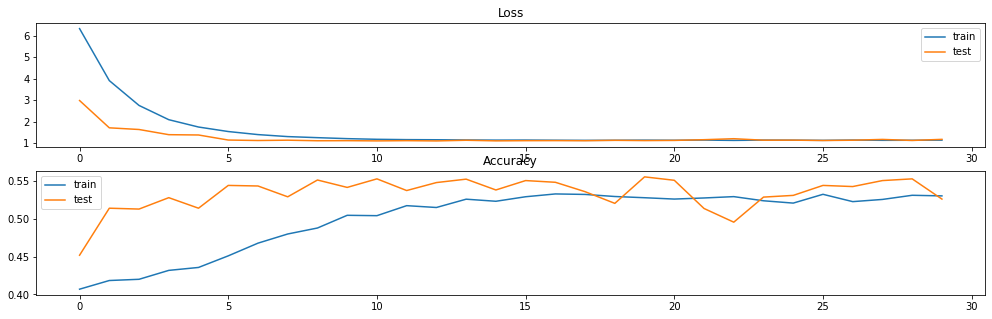

In [ ]:
#Evaluate training and testing accuracy
_, train_acc = model.evaluate(X_train, y_train, verbose=0)
_, test_acc = model.evaluate(X_test, y_test, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))
# plot loss during training
plt.subplot(211)
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
# plot accuracy during training
plt.subplot(212)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

In [ ]:
# demonstration of calculating metrics for a neural network model using sklearn 
from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report

# predict probabilities for test set
yhat_probs = model.predict(X_test, verbose=0)
# predict crisp classes for test set
classes_y=np.argmax(yhat_probs,axis=1)
# reduce to 1d array
yhat_probs = yhat_probs[:, 0]
yhat_classes = classes_y

y_test=np.argmax(y_test,axis=1)
# accuracy: (tp + tn) / (p + n)

#classification_report(y_test, yhat_classes)
accuracy = accuracy_score(y_test, yhat_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, yhat_classes,average="weighted")
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, yhat_classes,average="weighted")
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, yhat_classes,average="weighted")
print('F1 score: %f' % f1)

Accuracy: 0.525742
Precision: 0.518814
Recall: 0.525742
F1 score: 0.508416


# 3.2 CNN-LSTM - Run Adapted Model (Mendes,2020)

In [ ]:
#CNN-LSTM (Mendes,2020)
JSON_PATH = "JSON_PATH"
    
if __name__ == "__main__":

    # load data

    X, y = load_data(JSON_PATH)

    # create train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    
    #one hot encode the y values
    y_train = keras.utils.to_categorical(y_train, 4)
    y_test = keras.utils.to_categorical(y_test, 4)

    from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding, Conv2D, BatchNormalization, AveragePooling1D,Flatten,Reshape,Permute
    
    # build network topology
    model = Sequential()

    model.add(Conv1D(128,3,input_shape=(X.shape[1], X.shape[2])))

    model.add(Conv1D(64,3))
    model.add(BatchNormalization())
    model.add(AveragePooling1D())

    model.add(Conv1D(128,3))
    model.add(BatchNormalization())
    model.add(AveragePooling1D())

    model.add(Conv1D(256,3))
    model.add(BatchNormalization())
    model.add(AveragePooling1D())

    model.add(Conv1D(512,3))
    model.add(BatchNormalization())
    model.add(AveragePooling1D())

    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(BatchNormalization())

    model.add(Dropout(0.6))
    model.add(Reshape((14,512)))
    model.add(Permute((1,2), input_shape=(1024,1)))
    model.add(LSTM(128,return_sequences=True))
    model.add(LSTM(128))
    model.add(Dense(1024))

    model.add(Dropout(0.5))
    model.add(Dense(256))

    model.add(Dropout(0.25))
    model.add(Dense(64))
    model.add(Dense(32))
    model.add(Dense(4, activation='softmax'))

    optimiser = keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=optimiser,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    model.summary()

    # train model
    history_lstm = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=32, epochs=30)

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_55 (Conv1D)          (None, 257, 128)          5120      
                                                                 
 conv1d_56 (Conv1D)          (None, 255, 64)           24640     
                                                                 
 batch_normalization_66 (Bat  (None, 255, 64)          256       
 chNormalization)                                                
                                                                 
 average_pooling1d_44 (Avera  (None, 127, 64)          0         
 gePooling1D)                                                    
                                                                 
 conv1d_57 (Conv1D)          (None, 125, 128)          24704     
                                                                 
 batch_normalization_67 (Bat  (None, 125, 128)       

# Metrics evaluating CNN-LSTM model (Brownlee, 2022)

Train: 0.851, Test: 0.698


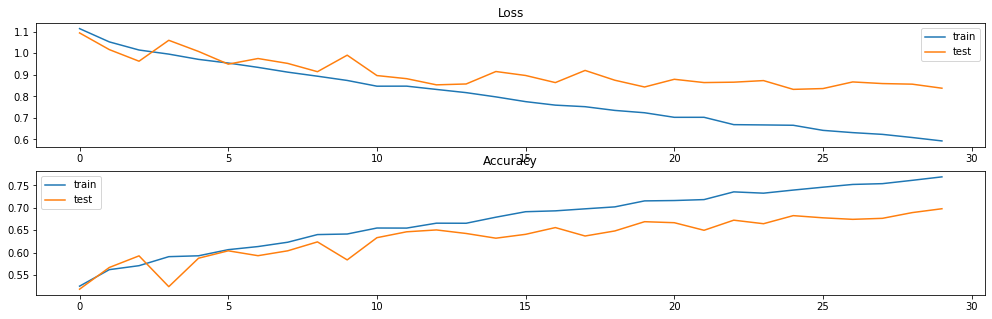

In [ ]:
#Evaluate Training and Testing Accuracy
_, train_acc = model.evaluate(X_train, y_train, verbose=0)
_, test_acc = model.evaluate(X_test, y_test, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))
# plot loss during training
plt.subplot(211)
plt.title('Loss')
plt.plot(history_lstm.history['loss'], label='train')
plt.plot(history_lstm.history['val_loss'], label='test')
plt.legend()
# plot accuracy during training
plt.subplot(212)
plt.title('Accuracy')
plt.plot(history_lstm.history['accuracy'], label='train')
plt.plot(history_lstm.history['val_accuracy'], label='test')
plt.legend()
plt.show()

In [ ]:
# predict probabilities for X testing set
yhat_probs = model.predict(X_test, verbose=0)

# predict genre for the testing set
genre_y = np.argmax(yhat_probs,axis=1)

# reduce to 1d array from one hot encoding 
yhat_probs = yhat_probs[:, 0]
yhat_genre = genre_y

y_test=np.argmax(y_test,axis=1)

accuracy = accuracy_score(y_test, yhat_genre)
print('Accuracy: %f' % accuracy)
precision = precision_score(y_test, yhat_classes,average="weighted")
print('Precision: %f' % precision)
recall = recall_score(y_test, yhat_classes,average="weighted")
print('Recall: %f' % recall)
f1 = f1_score(y_test, yhat_classes,average="weighted")
print('F1 score: %f' % f1)

Accuracy: 0.697858
Precision: 0.696304
Recall: 0.697858
F1 score: 0.696915


**References**

Benitez, C. (2022, May 13). 20 Spotify Statistics 2022: Usage, Revenue & More. Tone Island. https://toneisland.com/spotify-statistics/
Brownlee, J. (2022, August 18). How to Calculate Precision, Recall, F1, and More for Deep Learning Models. MachineLearningMastery.Com. https://machinelearningmastery.com/how-to-calculate-precision-recall-f1-and-more-for-deep-learning-models/
Defferrard, M. (2022). FMA: A Dataset For Music Analysis [Jupyter Notebook]. https://github.com/mdeff/fma (Original work published 2016)
Dobilas, S. (2022, March 5). LSTM Recurrent Neural Networks—How to Teach a Network to Remember the Past. Medium. https://towardsdatascience.com/lstm-recurrent-neural-networks-how-to-teach-a-network-to-remember-the-past-55e54c2ff22e
Doshi, K. (2021, May 21). Audio Deep Learning Made Simple: Sound Classification, step-by-step. Medium. https://towardsdatascience.com/audio-deep-learning-made-simple-sound-classification-step-by-step-cebc936bbe5
Gers, F. A., Schmidhuber, J., & Cummins, F. (2000). Learning to Forget: Continual Prediction with LSTM. Neural Computation, 12(10), 2451–2471. https://doi.org/10.1162/089976600300015015
Mendes, J. (2020). Deep Learning Techniques for Music Genre Classification and Building a Music Recommendation System.
Nandi, P. (2021, March 1). Recurrent Neural Nets for Audio Classification. Medium. https://towardsdatascience.com/recurrent-neural-nets-for-audio-classification-81cb62327990
Shukla, Y. (2021, December 28). Genre Classification using CNN. Medium. https://medium.com/@yashi4001/genre-classification-using-cnn-dcbc109b6d1d
Velardo, V. (2022). Musikalkemist/DeepLearningForAudioWithPython [Python]. https://github.com/musikalkemist/DeepLearningForAudioWithPython/blob/44a0e1880eee57a523780a1862cb8bf44963fbe8/12-%20Music%20genre%20classification:%20Preparing%20the%20dataset/code/extract_data.py (Original work published 2019)

